In [56]:
import pandas as pd
import numpy as np
import statsmodels
empty_series = pd.Series(dtype=np.float64)

import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 2.986997143324355


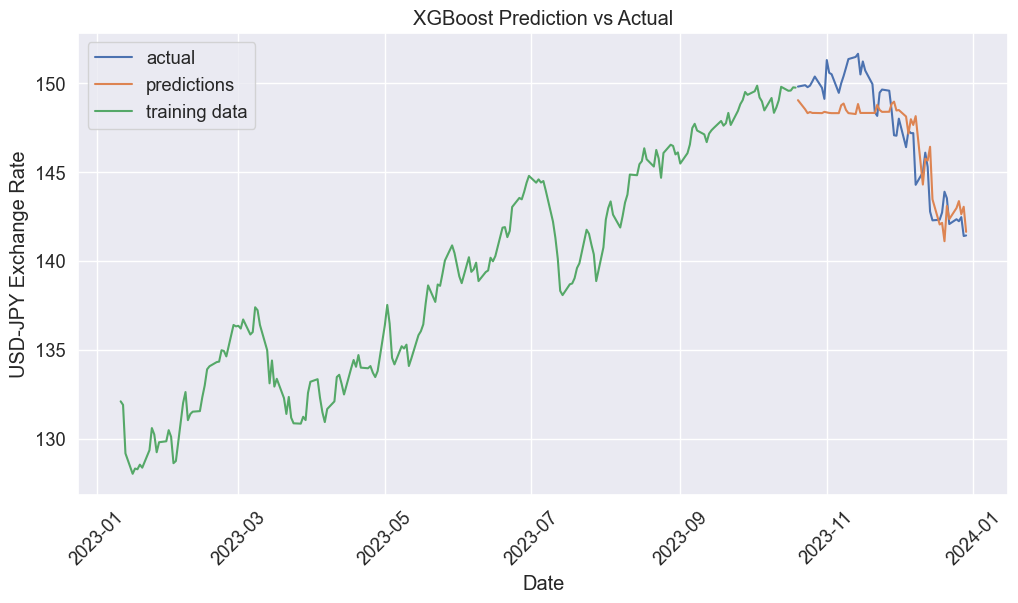

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Specify start and end dates
start_date = "2023-01-01"
end_date = "2024-01-01"

# Download USD-JPY data
data = yf.download("USDJPY=X", start=start_date, end=end_date)["Adj Close"]

def create_dataset(data, n_prev=7):
    """
    Create dataset for XGBoost model using the last n_prev data points as features
    and the next data point as the target.
    Returns X and y as DataFrames with associated dates as indices.
    """
    X, y = [], []
    dates = []
    for i in range(n_prev, len(data)):
        X.append(data.values[i-n_prev:i])  # Use 'Close' column as feature
        y.append(data.values[i])          # Use next 'Close' value as target
        dates.append(data.index[i])         # Save the associated date
    X_df = pd.DataFrame(X, index=dates, columns=[f't-{i}' for i in range(n_prev, 0, -1)])
    y_df = pd.DataFrame(y, index=dates, columns=['Next_Close'])
    return X_df, y_df

# Create dataset
X, y = create_dataset(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize XGBoost regressor
xgb_model = XGBRegressor()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = xgb_model.predict(X_test)

predictions_df = pd.DataFrame(predictions, index=y_test.index)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

plt.figure(figsize=(12, 6))

plt.plot(y_test, label='actual')
plt.plot(predictions_df, label='predictions')
plt.plot(y_train, label='training data')

plt.legend()
plt.title("XGBoost Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("USD-JPY Exchange Rate")

# Add gridlines and axis formatting
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## Classification

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 0.1650220476252789


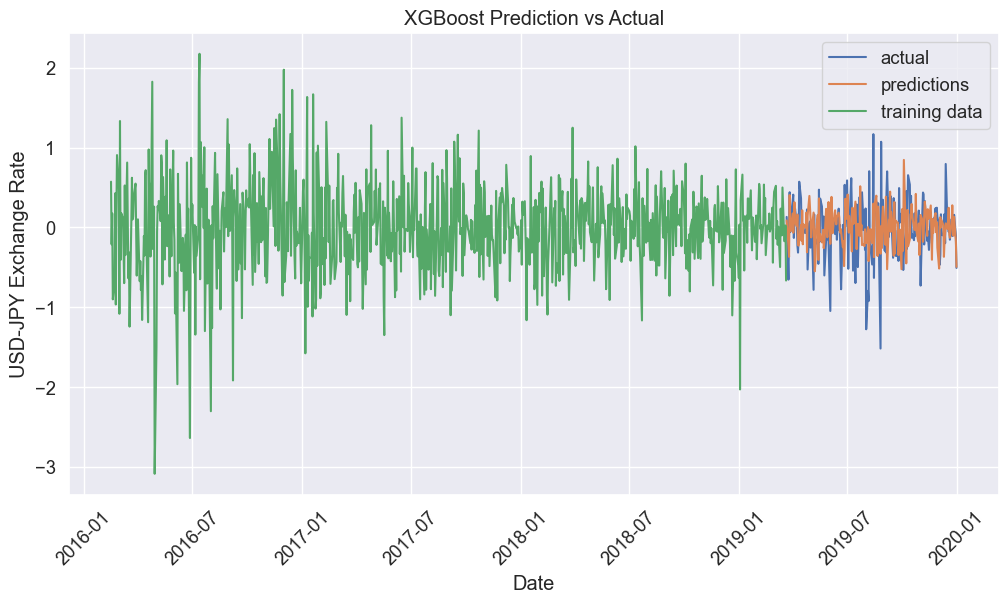

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Specify start and end dates
start_date = "2016-01-01"
end_date = "2020-01-01"

# Download USD-JPY data
#data = yf.download("USDJPY=X", start=start_date, end=end_date)["Adj Close"]

#y['% change']=((y['Next_Close']-X['USD/JPY -1'])/X['USD/JPY -1'])*100

usd_jpy = yf.download("USDJPY=X", start=start_date, end=end_date)["Adj Close"].rename("USD/JPY")
sp500 = yf.download("^SPX", start=start_date, end=end_date)["Adj Close"].rename("S&P 500")
n225 = yf.download("^N225", start=start_date, end=end_date)["Adj Close"].rename("Nikkei 225")
usd_jpy_change = usd_jpy.pct_change(periods=1).rename("USD/JPY % change")*100
sp500_change = sp500.pct_change(periods=1).rename("S&P 500 % change")*100
n225_change = n225.pct_change(periods=1).rename("Nikkei 225 % change")*100
data = pd.concat([usd_jpy, sp500, n225, usd_jpy_change, sp500_change, n225_change], axis=1).ffill().dropna()

def create_dataset(data, n_prev=30):
    """
    Create dataset for XGBoost model using the last n_prev data points as features
    and the next data point as the target.
    Returns X and y as DataFrames with associated dates as indices.
    """
    X, y = [], []
    dates = []
    for i in range(n_prev, len(data)):
        features = []
        feature_names = []
        for offset, val in enumerate(data['USD/JPY % change'].values[i-n_prev:i], start=-n_prev):
            features.append(val)
            feature_names.append(f'USD/JPY % change {offset}')
        
        for offset, val in enumerate(data['S&P 500 % change'].values[i-n_prev:i], start=-n_prev):
            features.append(val)
            feature_names.append(f'S&P 500 % change {offset}')

        for offset, val in enumerate(data['Nikkei 225 % change'].values[i-n_prev:i], start=-n_prev):
            features.append(val)
            feature_names.append(f'Nikkei 225 % change {offset}')

        X.append(features)  # Use 'Close' column as feature
        y.append(data['USD/JPY % change'].values[i])          # Use next 'Close' value as target
        dates.append(data.index[i])         # Save the associated date
    X_df = pd.DataFrame(X, index=dates, columns=feature_names)
    y_df = pd.DataFrame(y, index=dates, columns=['USD/JPY % change'])
    return X_df, y_df

# Create dataset
X, y = create_dataset(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize XGBoost regressor
xgb_model = XGBRegressor()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = xgb_model.predict(X_test)

predictions_df = pd.DataFrame(predictions, index=y_test.index)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

plt.figure(figsize=(12, 6))

plt.plot(y_test, label='actual')
plt.plot(predictions_df, label='predictions')
plt.plot(y_train, label='training data')

plt.legend()
plt.title("XGBoost Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("USD-JPY Exchange Rate")

# Add gridlines and axis formatting
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [111]:
n_prev = 30
i = n_prev
for val in enumerate(data['USD/JPY'].values[i-n_prev:i], start=-n_prev):
     print(val)

(-30, 119.46700286865234)
(-29, 119.10199737548828)
(-28, 118.61000061035156)
(-27, 117.54000091552734)
(-26, 117.08000183105469)
(-25, 117.6500015258789)
(-24, 117.83000183105469)
(-23, 117.42500305175781)
(-22, 118.2030029296875)
(-21, 116.98999786376953)
(-20, 117.38400268554688)
(-19, 117.56500244140625)
(-18, 117.13400268554688)
(-17, 117.92400360107422)
(-16, 118.5719985961914)
(-15, 118.22799682617188)
(-14, 118.37999725341797)
(-13, 118.46700286865234)
(-12, 118.93000030517578)
(-11, 121.33999633789062)
(-10, 120.83999633789062)
(-9, 119.85600280761719)
(-8, 118.12000274658203)
(-7, 116.86599731445312)
(-6, 116.94999694824219)
(-5, 115.66799926757812)
(-4, 115.19100189208984)
(-3, 113.25199890136719)
(-2, 112.49700164794922)
(-1, 113.66999816894531)


## Turning this into a classification problem

<Axes: >

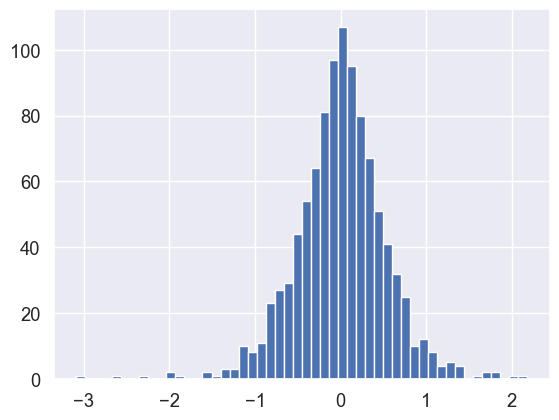

In [90]:
y.describe()

y['USD/JPY % change'].hist(bins=50)

In [91]:
# Calculate percentiles
percentiles = y['USD/JPY % change'].quantile([0.33, 0.66])

# Access specific percentiles
percentile_33 = percentiles.loc[0.33]
percentile_66 = percentiles.loc[0.66]

print("33rd Percentile:")
print(percentile_33)
print("\n66th Percentile:")
print(percentile_66)

33rd Percentile:
-0.17801130441901236

66th Percentile:
0.1793154865608848


Classes:
low loss day = lower than -0.35
loss day = between -0.1 and -0.35 (20th to 40th percentile)
neutral day = between -0.1 and 0.1 (40th to 60th percentile)
gain day = between 0.1 and 0.35 (60th to 80th percentile)
high gain day = higher than 0.35

In [92]:
# Define boundaries
boundaries = [-float('inf'), -0.18, 0.18, float('inf')]

# Define labels for each class
#labels = ['low loss day', 'loss day', 'neutral day', 'gain day', 'high gain day']

labels = ['loss', 'neutral', 'gain']

# Categorize the data
y['classified'] = pd.cut(y['USD/JPY % change'], bins=boundaries, labels=labels)

# Print the DataFrame with the new 'class' column
y

,USD/JPY % change,classified
2016-02-16,0.573591,gain
2016-02-17,-0.211680,loss
2016-02-18,0.175313,neutral
2016-02-19,-0.901294,loss
2016-02-22,-0.671966,loss
...,...,...
2019-12-25,0.000914,neutral
2019-12-26,-0.012799,neutral
2019-12-27,0.158177,neutral
2019-12-30,-0.104068,neutral


In [93]:
from xgboost import XGBClassifier

#y['classified_int'] = y['classified'].replace({'low loss day': 0, 'loss day': 1, 'neutral day': 2, 'gain day': 3, 'high gain day': 4})

y['classified_int'] = y['classified'].replace({'loss': 0, 'neutral': 1, 'gain': 2})

# Initialize XGBoost regressor
xgb_model = XGBClassifier(n_estimators=100)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y['classified_int'], test_size=0.2, random_state=42, shuffle=True)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

/var/folders/48/5v6k8sp52ss918pl5z5tnf4w0000gn/T/ipykernel_3385/4132225338.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y['classified_int'] = y['classified'].replace({'loss': 0, 'neutral': 1, 'gain': 2})
/var/folders/48/5v6k8sp52ss918pl5z5tnf4w0000gn/T/ipykernel_3385/4132225338.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y['classified_int'] = y['classified'].replace({'loss': 0, 'neutral': 1, 'gain': 2})


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

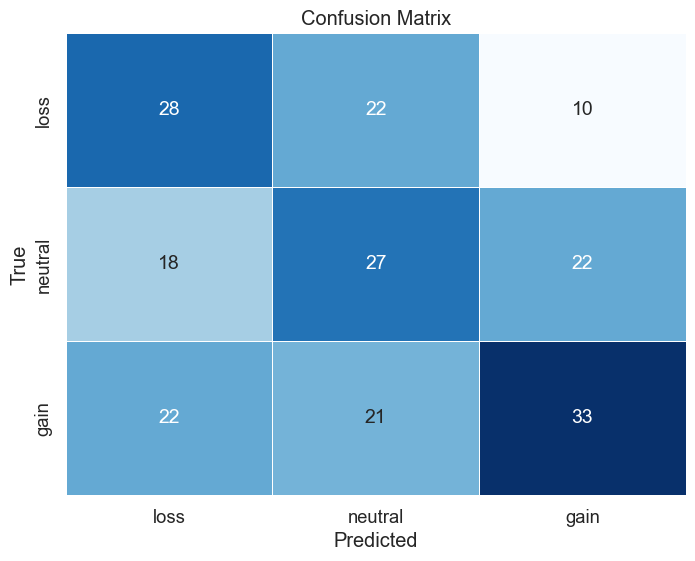

In [94]:
# Make predictions on the testing data
predictions = xgb_model.predict(X_test)

predictions_df = pd.DataFrame(predictions, index=y_test.index)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions_df)

#class_labels = ['low loss day', 'loss day', 'neutral day', 'gain day', 'high gain day']

class_labels = ['loss', 'neutral', 'gain']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={'fontsize': 14}, linewidths=0.5,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Statistics

### Accuracy
(TP + TN) / (TP + TN + FP + FN)

In [107]:
accuracy = cm.diagonal()/cm.sum(axis=1)
print("loss accuracy = "+str(round(accuracy[0]*100))+"%")
print("neutral accuracy = "+str(round(accuracy[1]*100))+"%")
print("gain accuracy = "+str(round(accuracy[2]*100))+"%")

loss accuracy = 47%
neutral accuracy = 40%
gain accuracy = 43%


In [110]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_df))

              precision    recall  f1-score   support

           0       0.41      0.47      0.44        60
           1       0.39      0.40      0.39        67
           2       0.51      0.43      0.47        76

    accuracy                           0.43       203
   macro avg       0.44      0.43      0.43       203
weighted avg       0.44      0.43      0.43       203

